## Segmentation

Grouping together customers on the basis of parameter of interest - Gender,Age, Spending Behaviour, Frequency of Transaction,Demography and so on. Segmentation aids businesses to run targeted campaigns to right audience. Segmentation helps in finding loyal customers as well as customers on the verge of leaving. The model may reveal segments previously unnoticed by the companies as well.

We'll be looking at segmenting customers into loyal and those in verge of churning out.

## RFM (Recency - Frequency - Monetary Value). 

Theoretically we will have segments like below:

- Low Value: Customers who are less active than others (no recent buying), not very frequent buyer/visitor and generates very low - zero - maybe negative revenue indication high chance of churn.
- Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue and have transacted in the near past.
- High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity (recent purchase). Most loyal customers.

Based on this, businesses can strategise to retain the loyal customers and take actions to improve the relation with the customers who are about to churn.

## Workflow

As the methodology, we need to calculate Recency, Frequency and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. 

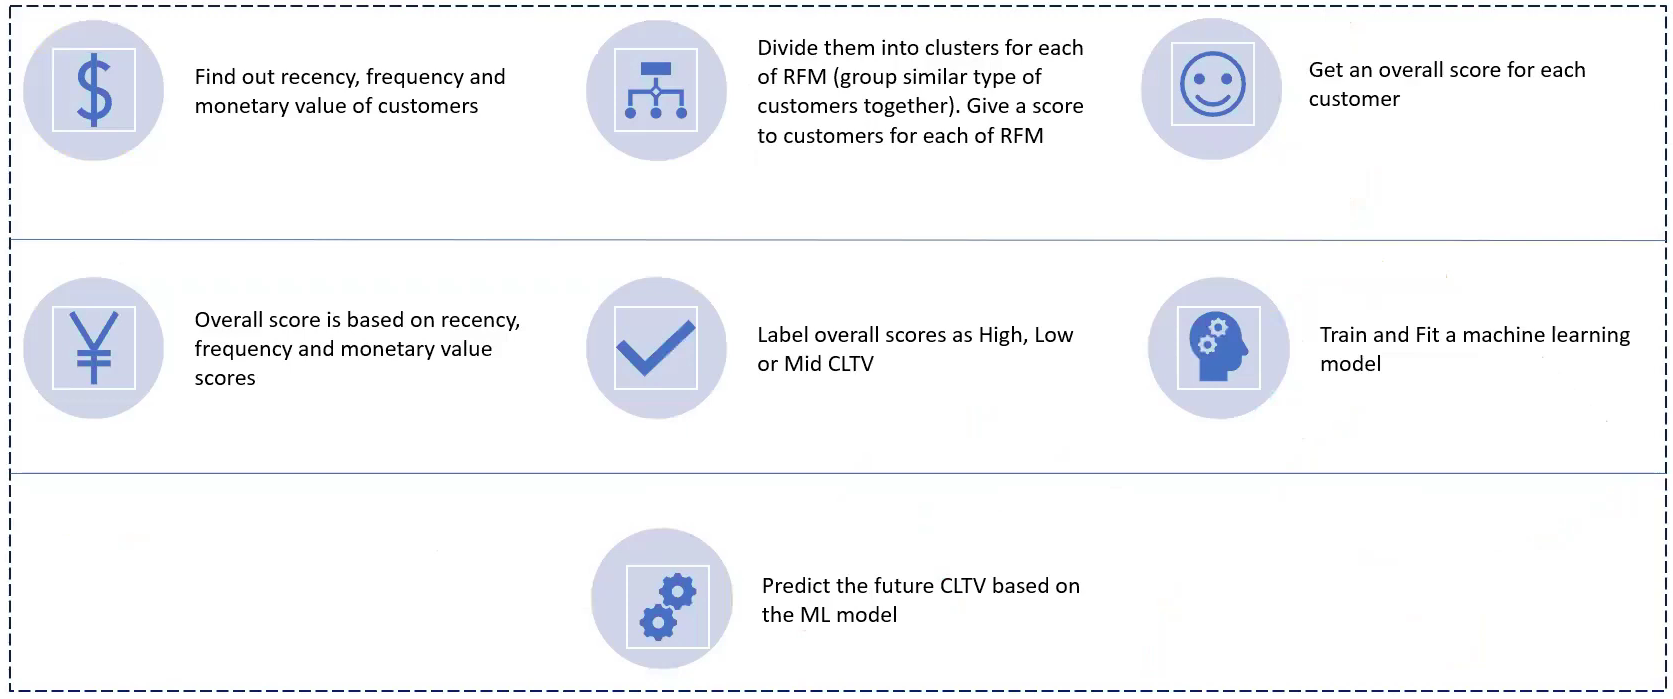

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plydata.cat_tools as cat
import plotnine as pn

pn.options.dpi=300
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set()

## Data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. (UCI Machine Learning Repository).

**Attribute Information:**

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

In [2]:
df=pd.read_csv(r"F:\Data Science and Machine Learning\Data Sets\Customer Analytics\Customer Life Time Value\customer_segmentation.csv", encoding='cp1252')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


## Data Exploration & Preprocessing

We'll look at the following :
- Missing Values
- Duplicates
- Dtype Inconsistencies
- Cardinality of Categorical features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Missing Values** : Since we are doing customer segmentation, records with no CustomerId will be of no use to us.

In [5]:
df.dropna(subset="CustomerID",inplace=True)

Our Analysis is restricted to only the customers from UK. 

In [9]:
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

**Data Duplication**

Data is recorded such that there will be double entry when a customer purchases multiple category products. This is problamatic. Keeping double entry records will increase the frequency measure value incorrectly, whereas if we remove it then will decrease the Monetary measure value. We'll need to keep different dataframes for calculating each of the RFM measures.

In [10]:
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


**Dtype Inconsistencies**

In [11]:
df_uk['InvoiceDate']=pd.DatetimeIndex(df_uk['InvoiceDate'])
df_uk['InvoiceYearMonth'] = df_uk['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


**Categoric Features**

In [13]:
categorical_features = [i for i in df_uk.columns if df_uk[i].dtype=="object"]
df_uk[categorical_features].head()

,InvoiceNo,StockCode,Description,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [15]:
for i in categorical_features:
    print("Cardinality of Feature {} is : ".format(i),len(df_uk[i].value_counts()))

Cardinality of Feature InvoiceNo is :  19857
Cardinality of Feature StockCode is :  3661
Cardinality of Feature Description is :  3860
Cardinality of Feature Country is :  1


We don't really have any categories here.

**Numeric Features**

In [16]:
numeric_features=[i for i in df_uk.columns if df_uk[i].dtype not in ["object","datetime64[ns]"]]
df_uk[numeric_features].head()

,Quantity,UnitPrice,CustomerID,InvoiceYearMonth
0,6,2.55,17850.0,201012
1,6,3.39,17850.0,201012
2,8,2.75,17850.0,201012
3,6,3.39,17850.0,201012
4,6,3.39,17850.0,201012


In [17]:
df_uk[['Quantity','UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,361878.0,11.077029,263.129266,-80995.0,2.00,4.00,12.00,80995.0
UnitPrice,361878.0,3.256007,70.654731,0.0,1.25,1.95,3.75,38970.0


**Data Validation**

We can see from summary statistics that the Quantity Column contains negative values. This will be problamatic in our Monetary measure. We'll filter out the records with negative values for quantity.

In [18]:
df_uk=df_uk[(df_uk["Quantity"]>0)]

### Recency - Recency Score

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

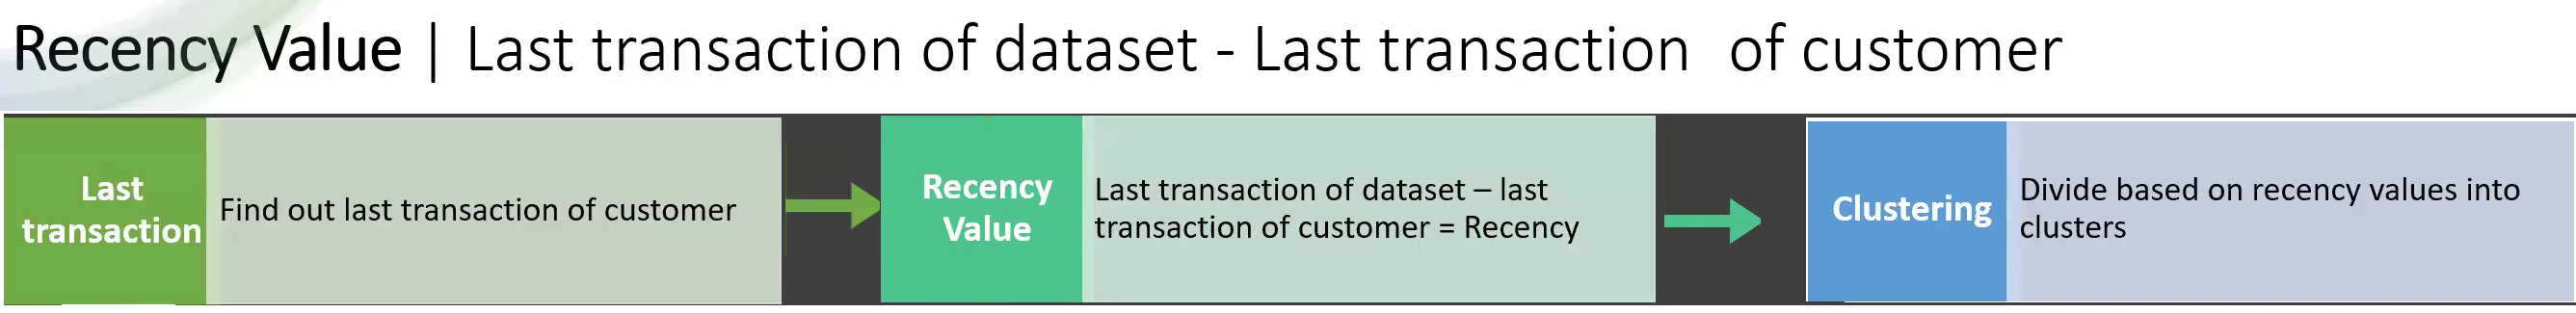

In [30]:
# Create a dataframe to store UserId-Recency-Frequency-Monetary measures along with their scores
df_user = pd.DataFrame(df_uk['CustomerID'].unique())
df_user.columns = ['CustomerID']
df_user.head()

,CustomerID
0,17850.0
1,13047.0
2,13748.0
3,15100.0
4,15291.0


Since we are calculating recency, we need to know when last the person bought something. Let us calculate the last date of transaction for a person.

In [28]:
Latest_Date = df_uk['InvoiceDate'].max()
Latest_Date

Timestamp('2011-12-09 12:49:00')

In [24]:
#get the max purchase date for each customer and create a dataframe with it
df_latest_purchase = df_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_latest_purchase.columns = ['CustomerID','LatestPurchaseDate']
df_latest_purchase.head()

,CustomerID,LatestPurchaseDate
0,12346.0,2011-01-18 10:01:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [29]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
df_latest_purchase['Recency'] = (Latest_Date - df_latest_purchase['LatestPurchaseDate']).dt.days
df_latest_purchase.head()

,CustomerID,LatestPurchaseDate,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


Higher the Recency value, more further back in past the transaction. Recency of 325 implies the CustomerID 12346's last purchase was 325 days ago. He is an example of inactive/ customer on the verge of leaving.

In [31]:
#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_latest_purchase[['CustomerID','Recency']], on='CustomerID')
df_user.head()

,CustomerID,Recency
0,17850.0,371
1,13047.0,31
2,13748.0,95
3,15100.0,333
4,15291.0,25


**Assign Recency Score**

We can either use a rule based approach where we can partition the distribution into quartiles and assign labels or we can use unsupervised learning approach of clustering.

Here we are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

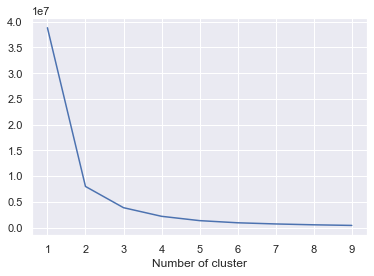

In [32]:
from sklearn.cluster import KMeans

sse={} # error
user_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_recency)
    user_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 here.

In [36]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
df_user['RecencyCluster'] = kmeans.fit_predict(df_user[['Recency']])
df_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,371,1
1,13047.0,31,0
2,13748.0,95,3
3,15100.0,333,1
4,15291.0,25,0


In [37]:
df_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,371,1
1,13047.0,31,0
2,13748.0,95,3
3,15100.0,333,1
4,15291.0,25,0


**Ordering clusters**

We have a cluster corresponding to each customerID. But each cluster is randomly assigned. Cluster 2 is not better than cluster 1 for e.g. and so on. We want to give clusters according to most recent transactions.

In [38]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1955.0,18.619949,13.765856,0.0,7.0,17.0,29.0,49.0
1,444.0,306.873874,39.693832,249.0,272.0,302.0,336.0,373.0
2,567.0,190.373898,32.266194,136.0,164.0,188.0,217.0,248.0
3,955.0,80.580105,23.752273,50.0,60.5,74.0,96.0,135.0


We will first find the mean of recency value corresponding to each cluster. Then we will sort these values. Let's say cluster 3 has the most recent transactions mean value. From the above table we see that cluster 1(mean recency 304) > cluster 3 > cluster 2 > cluster 0. That means that cluster 1 is most inactive and cluster 0 is most recent. We will give indices to these clusters as 0,1,2,3. So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on. Now we will drop the original cluster numbers and replace them with 0,1,2,3. 

In [39]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [40]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,444.0,306.873874,39.693832,249.0,272.0,302.0,336.0,373.0
1,567.0,190.373898,32.266194,136.0,164.0,188.0,217.0,248.0
2,955.0,80.580105,23.752273,50.0,60.5,74.0,96.0,135.0
3,1955.0,18.619949,13.765856,0.0,7.0,17.0,29.0,49.0


The clusters are arranged according to inactiviuty. Cluster 0 now is most inactive, cluster 3 is most active.

count    3921.000000
mean       91.188472
std        99.528995
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

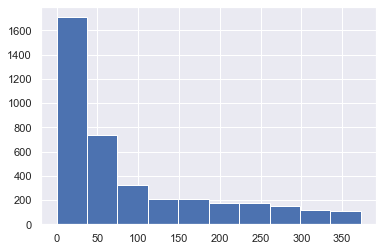

In [70]:
df_user['Recency'].hist();
df_user['Recency'].describe()

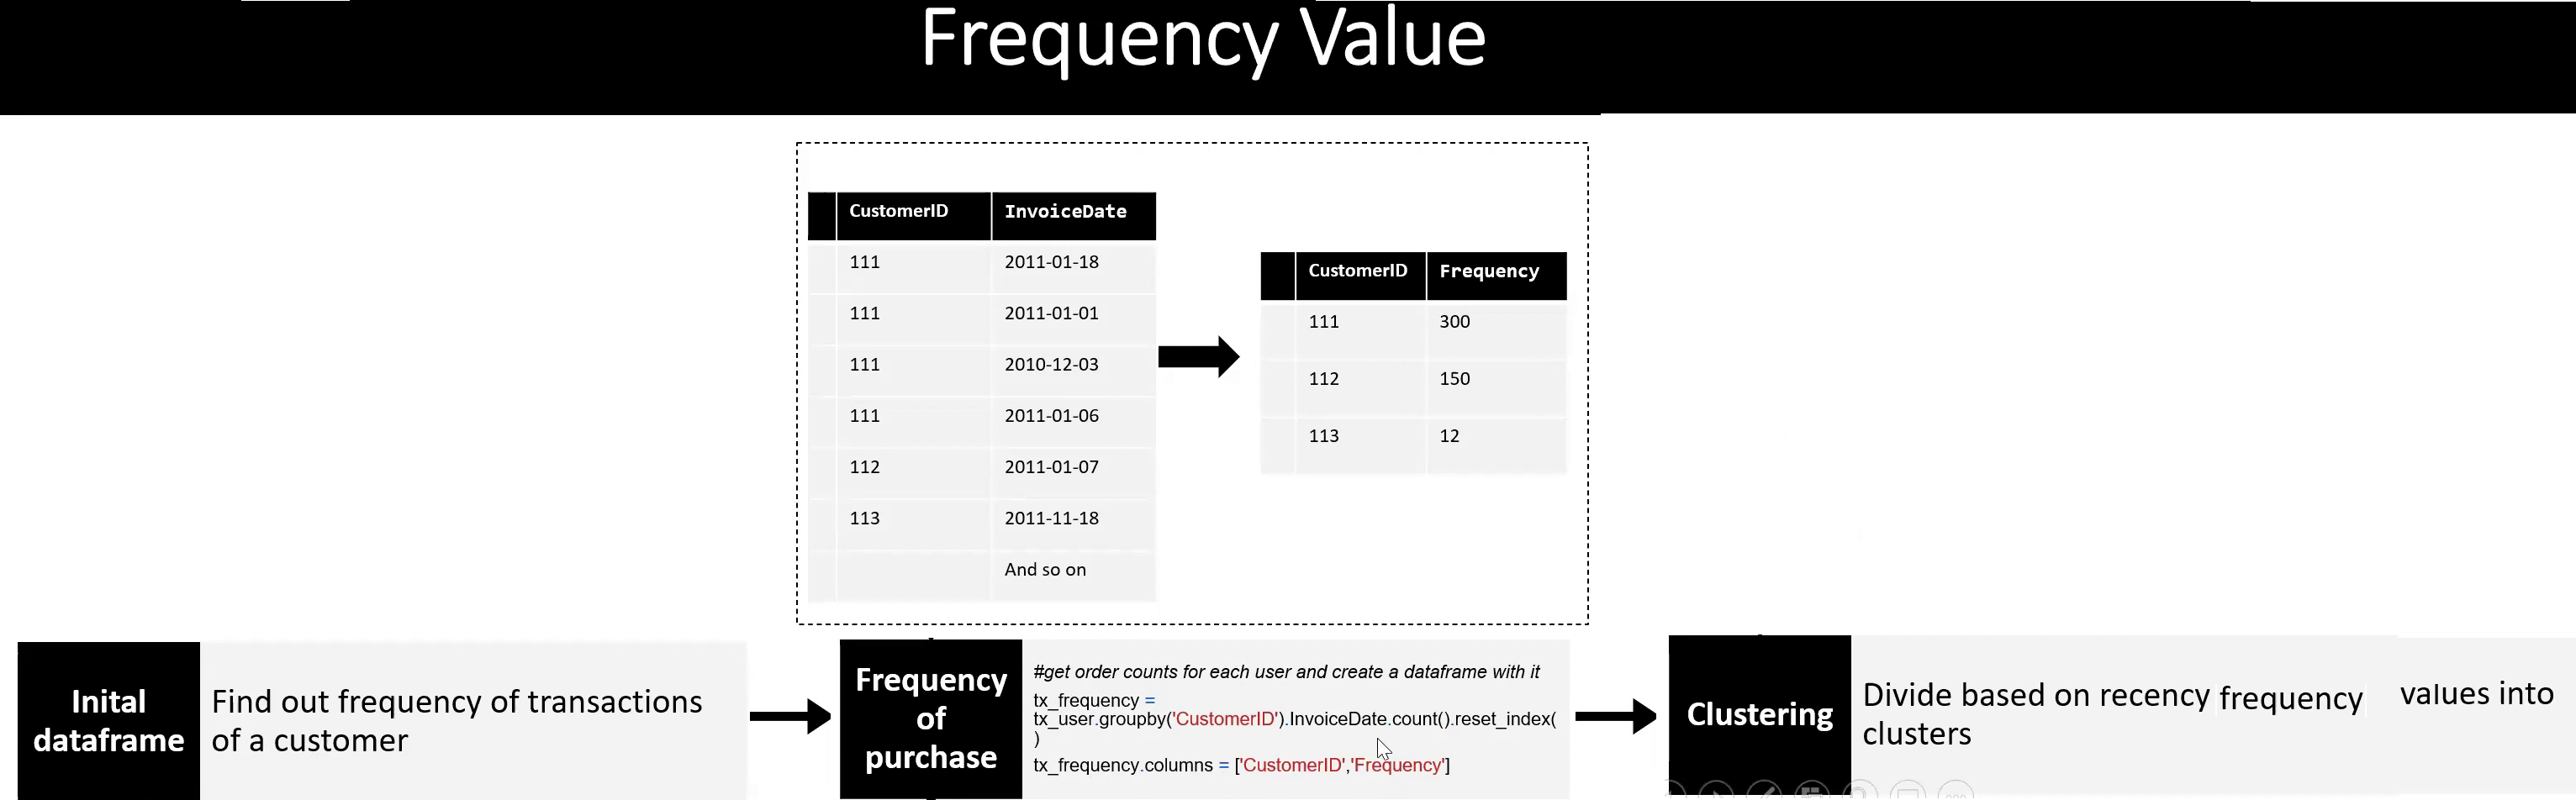

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database. This is a simple transaction table where a customer made purchase only once a day, so we can use the invoicedate column for frequency count, else we could use transaction id for counting frequency.

**Note:** This is where we have to create a new dataframe to filterout the double entries in transactions.

In [54]:
df_uk_freq=df_uk[~df_uk.duplicated(subset=["InvoiceNo","Description"])]
df_uk_freq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344362 entries, 0 to 361877
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         344362 non-null  object        
 1   StockCode         344362 non-null  object        
 2   Description       344362 non-null  object        
 3   Quantity          344362 non-null  int64         
 4   InvoiceDate       344362 non-null  datetime64[ns]
 5   UnitPrice         344362 non-null  float64       
 6   CustomerID        344362 non-null  float64       
 7   Country           344362 non-null  object        
 8   InvoiceYearMonth  344362 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 26.3+ MB


In [58]:
#get order counts for each user and create a dataframe with it
df_frequency = df_uk_freq.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']
df_frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,103
2,12748.0,4284
3,12749.0,199
4,12820.0,59


In [59]:
#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='CustomerID')
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,371,0,297
1,15100.0,333,0,3
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


**Frequency clusters**

Determine the right number of clusters for K-Means by elbow method

C:\Users\ASUS\AppData\Local\Temp/ipykernel_7588/1626761508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ASUS\AppData\Local\Temp/ipykernel_7588/1626761508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ASUS\AppData\Local\Temp/ipykernel_7588/1626761508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

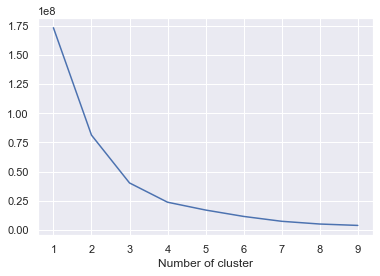

In [60]:
sse={} # error
user_frequency = df_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_frequency)
    user_frequency["clusters"] = kmeans.labels_  #cluster names corresponding to frequency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

By Elbow method, clusters number should be 4 as after 4, the graph goes down.

In [61]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
df_user['FrequencyCluster']=kmeans.fit_predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency', df_user, True )
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,371,0,297,1
1,15808.0,305,0,191,1
2,14688.0,7,3,321,1
3,16029.0,38,3,240,1
4,13408.0,1,3,478,1


In [62]:
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3467.0,47.593020,42.639584,1.0,14.00,33.0,70.00,180.0
1,429.0,314.349650,127.734333,182.0,213.00,272.0,380.00,756.0
2,22.0,1257.363636,490.964604,799.0,936.75,1080.0,1407.75,2660.0
3,3.0,5613.000000,1660.929559,4284.0,4682.00,5080.0,6277.50,7475.0


Cluster with max frequency is cluster 3, least frequency cluster is cluster 0.

count    3921.000000
mean       87.825045
std       210.177395
min         1.000000
25%        16.000000
50%        40.000000
75%        97.000000
max      7475.000000
Name: Frequency, dtype: float64

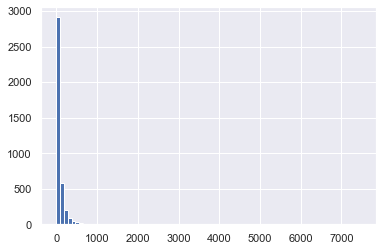

In [76]:
df_user['Frequency'].hist(bins=80);
df_user['Frequency'].describe()

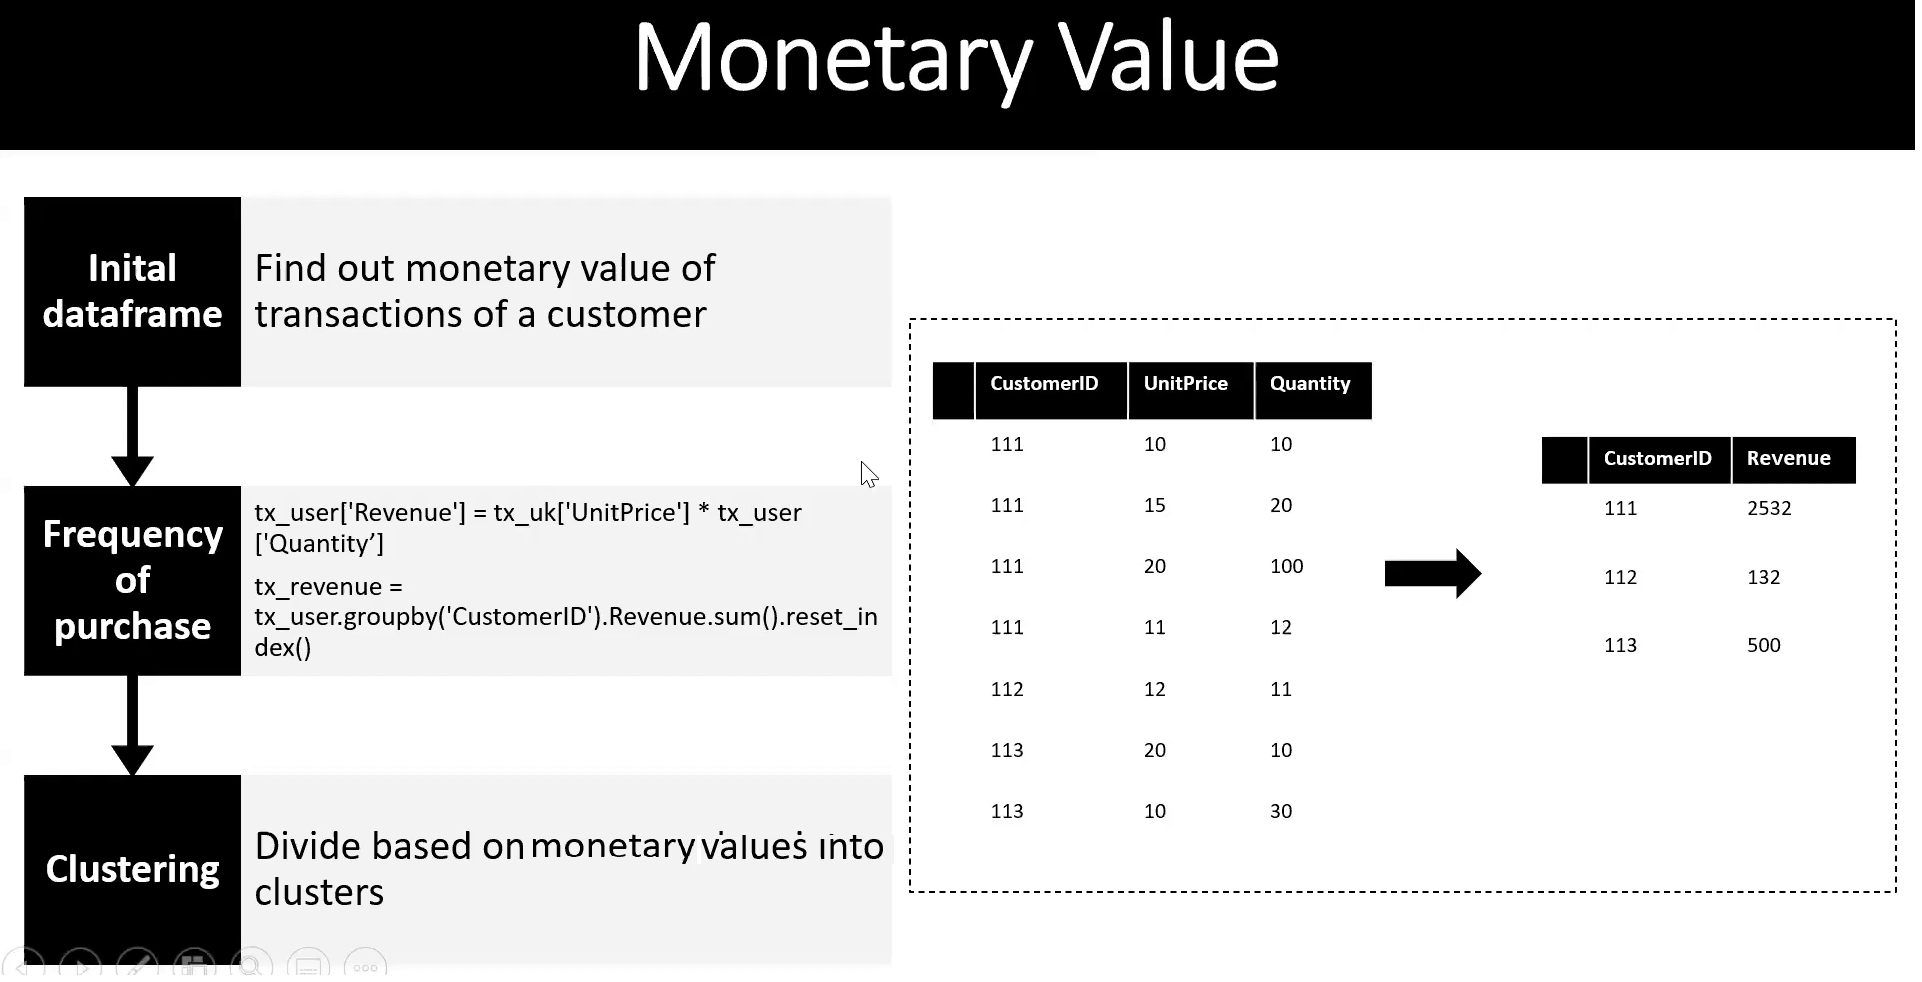

Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [78]:
#calculate revenue for each customer
df_uk['Revenue'] = df_uk['UnitPrice'] * df_uk['Quantity']
df_revenue = df_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [79]:
#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='CustomerID')
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,371,0,297,1,5391.21
1,15808.0,305,0,191,1,3734.97
2,14688.0,7,3,321,1,5630.87
3,16029.0,38,3,240,1,81024.84
4,13408.0,1,3,478,1,28117.04


C:\Users\ASUS\AppData\Local\Temp/ipykernel_7588/3884239494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ASUS\AppData\Local\Temp/ipykernel_7588/3884239494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ASUS\AppData\Local\Temp/ipykernel_7588/3884239494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

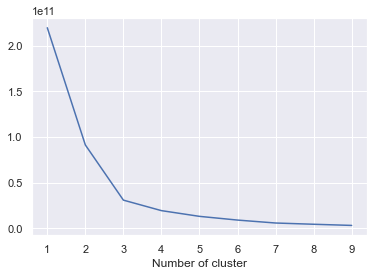

In [80]:
sse={} # error
df_revenue = df_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

**Revenue Clusters**

From elbow's method, we find that clusters can be 3 or 4. Lets take 4 as the number of clusters

In [81]:
#apply clustering
kmeans = KMeans(n_clusters=4)
df_user['RevenueCluster'] = kmeans.fit_predict(df_user[['Revenue']])

#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,371,0,297,1,5391.21,1
1,14688.0,7,3,321,1,5630.87,1
2,13408.0,1,3,478,1,28117.04,1
3,13767.0,1,3,368,1,17220.36,1
4,15513.0,32,3,307,1,14758.22,1


In [82]:
#show details of the dataframe
df_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3716.0,1004.927071,1055.533730,0.00,285.8525,604.13,1352.9975,5346.23
1,179.0,9713.404078,5139.408715,5360.63,6304.4150,7832.47,10945.2950,28882.44
2,23.0,52726.201739,16490.086325,31833.68,38535.1750,51527.30,62903.7600,91062.38
3,3.0,207560.196667,46963.820480,168472.50,181511.6450,194550.79,227104.0450,259657.30


Cluster 3 has max revenue, cluster 0 has lowest revenue

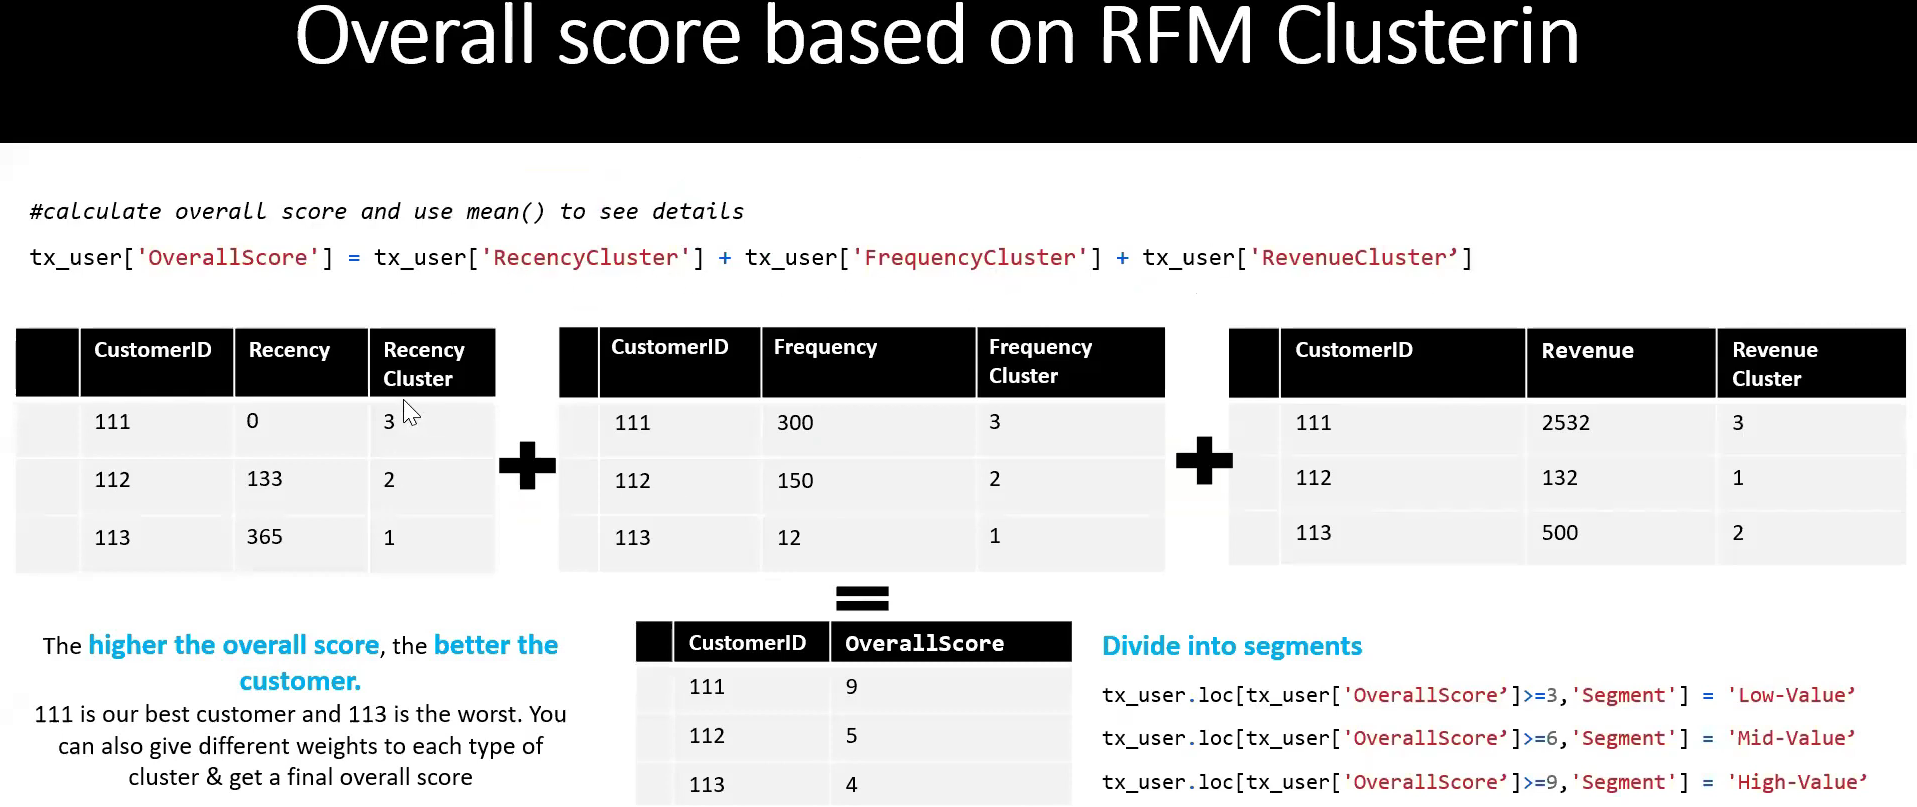

We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them. Here we have given equal scores to each measure, based on domain requirement we can give weightage as needed.

In [83]:
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,306.763636,21.786364,347.636341
1,191.091234,31.159213,523.716531
2,82.094565,44.876087,956.043002
3,22.318831,66.193506,1209.945734
4,14.463259,267.153355,3939.364505
5,9.899160,402.327731,10997.589748
6,6.142857,869.761905,34371.246190
7,3.000000,1255.666667,119398.583333
8,1.333333,5613.000000,46625.363333


Score 8 is our best customer, score 0 is our worst customer. However care should be given to imbalance in data before making a decision.

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Revenue, dtype: float64

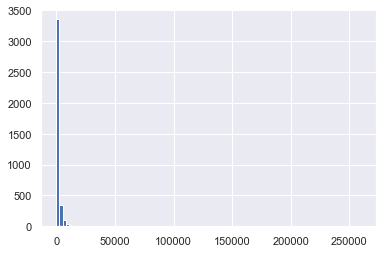

In [86]:
df_user['Revenue'].hist(bins=100);
df_user['Revenue'].describe()

In [88]:
df_user['Segment'] = 'Low-Value'
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,371,0,297,1,5391.21,1,2,Low-Value
1,14688.0,7,3,321,1,5630.87,1,5,Low-Value
2,13408.0,1,3,478,1,28117.04,1,5,Low-Value
3,13767.0,1,3,368,1,17220.36,1,5,Low-Value
4,15513.0,32,3,307,1,14758.22,1,5,Low-Value


In [89]:
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value' 
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,371,0,297,1,5391.21,1,2,Low-Value
1,14688.0,7,3,321,1,5630.87,1,5,High-Value
2,13408.0,1,3,478,1,28117.04,1,5,High-Value
3,13767.0,1,3,368,1,17220.36,1,5,High-Value
4,15513.0,32,3,307,1,14758.22,1,5,High-Value


**Actions on Insights**
- Cross Selling to loyal customers. Offer loyalty programs.Same Day Shipping, Early Access etc.
- Offer coupons, targeted product placement etc to bring them back in.

## K-Means Clustering Model

Alternative to RFM Model. Instead of using RFM Total score to categorize customers by rule based approach, we'll use K Means clustering to create customer segments using the RFM features.

### Preprocessing features for Clustering
- Normal Transformation
- Rescaling 

We'll transform the skewed distributions to a more normally distributed distribution.  Since the distributions are right skewed we can try using sqrt,log,log10,Inverse,BoxCox transformation as a fix. Note that we should handle the negatives and 0 values if any in case of log transformations.

In [ ]:
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
df_user['Recency'] = [handle_neg_n_zero(x) for x in df_user.Recency]
df_user['Revenue'] = [handle_neg_n_zero(x) for x in df_user.Revenue]

**Transformations**
- Sqrt, Log,Log10,Inverse,BoxCox

<Axes: ylabel='Frequency'>

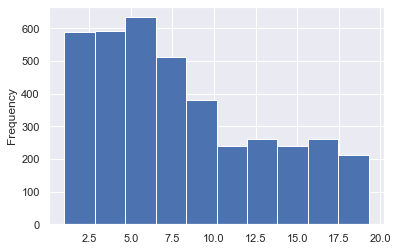

In [128]:
np.sqrt(df_user['Recency']).plot(kind='hist')

<Axes: ylabel='Frequency'>

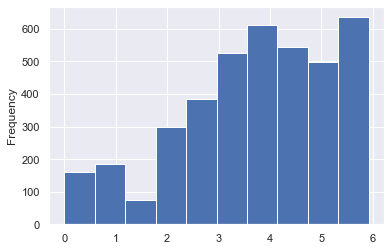

In [127]:
np.log(df_user['Recency']).plot(kind='hist')

<Axes: ylabel='Frequency'>

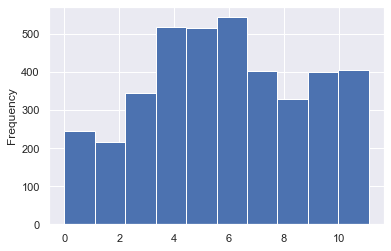

In [129]:
from scipy import stats

pd.Series(stats.boxcox(df_user['Recency'])[0]).plot(kind='hist')

Box Cox Transformation for Recency Feature.

<Axes: ylabel='Frequency'>

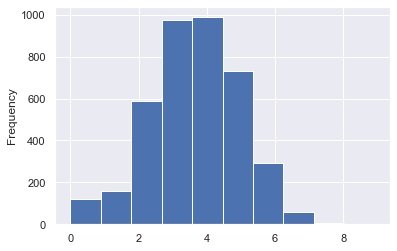

In [131]:
np.log(df_user['Frequency']).plot(kind='hist')

Log Transformation for Frequency feature.

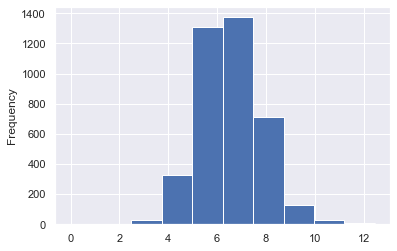

In [137]:
np.log(df_user['Revenue']).plot(kind='hist');

Log transformation for Revenue feature.

In [147]:
df_user['Recency_Transformed']= np.round(stats.boxcox(df_user['Recency'])[0],3)
df_user['Frequency_Transformed']=np.round(np.log(df_user['Frequency']),3)
df_user['Revenue_Transformed']=np.round(np.log(df_user['Revenue']),3)

**Rescaling Features**

As the clustering algorithm works by optimizing a distance based metric we'll need to standardize our dataset to avoid higher magnitude influence.

In [163]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(df_user[['Recency_Transformed','Frequency_Transformed','Revenue_Transformed']])

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data,columns = ['Recency(T)','Frequency(T)','Revenue(T)'],index=df_user.index)

Scaled_Data.head()

,Recency(T),Frequency(T),Revenue(T)
0,1.765067,1.543105,1.639620
1,-1.177476,1.601034,1.673987
2,-1.976055,1.901214,2.959176
3,-1.976055,1.704103,2.567545
4,-0.307251,1.567932,2.444461


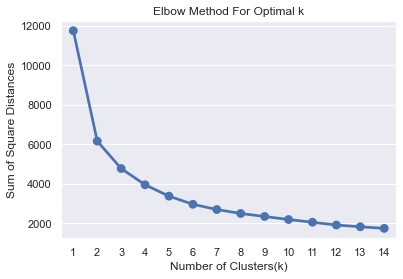

In [164]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [171]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
df_user['Cluster'] = KMean_clust.labels_
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Recency_Transformed,Frequency_Transformed,Revenue_Transformed,Cluster,Color
0,17850.0,371,0,297,1,5391.21,1,2,Low-Value,11.070,5.694,8.593,1,blue
1,14688.0,7,3,321,1,5630.87,1,5,High-Value,2.363,5.771,8.636,1,blue
2,13408.0,1,3,478,1,28117.04,1,5,High-Value,0.000,6.170,10.244,1,blue
3,13767.0,1,3,368,1,17220.36,1,5,High-Value,0.000,5.908,9.754,1,blue
4,15513.0,32,3,307,1,14758.22,1,5,High-Value,4.938,5.727,9.600,1,blue


In [172]:
df_user['Cluster'].value_counts()

Cluster
0    1634
2    1270
1    1017
Name: count, dtype: int64

<Figure size 504x504 with 0 Axes>

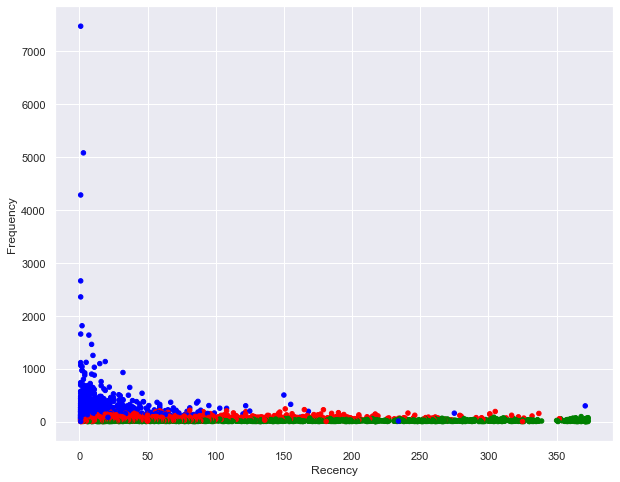

In [170]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
df_user['Color'] = df_user['Cluster'].map(lambda p: Colors[p])
ax = df_user.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = df_user['Color']
)